In [9]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

path2data="./data/training_set/"
import warnings
warnings.filterwarnings('ignore')
    


In [10]:

img_list = [i for i in os.listdir(path2data) if i.find("Annotation") is -1 and i.endswith(".png")]
ann_list = [i for i in os.listdir(path2data) if i.find("Annotation") is not -1]

print(f"# Img list: {len(img_list)}")

print(f"# Annotation list: {len(ann_list)}")

# Img list: 999
# Annotation list: 999


In [11]:
np.random.seed(2019)
rnd_list = np.random.choice(img_list, 3)
rnd_list

array(['490_HC.png', '361_HC.png', '841_HC.png'], dtype='<U11')

In [13]:
import matplotlib.pyplot as plt
from PIL import Image
from scipy import ndimage as ndi
from skimage.segmentation import mark_boundaries

In [14]:
def show_img_mask(img,mask):
    img_mask=mark_boundaries(np.array(img), np.array(mask, dtype = np.bool), outline_color=(0,1,0), color=(0,1,0))
    plt.imshow(img_mask)

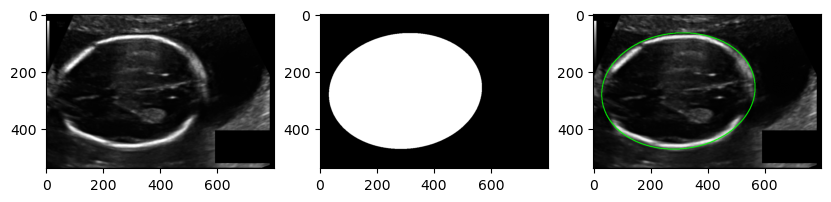

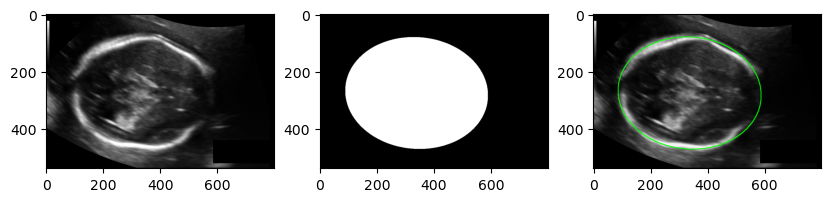

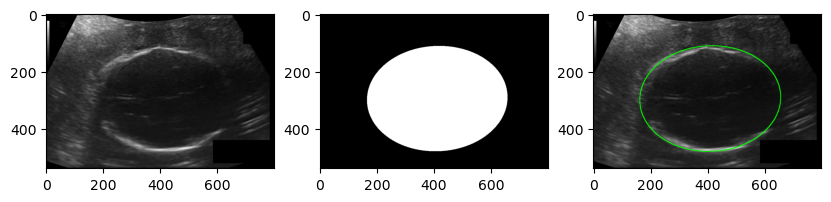

In [15]:
for i in rnd_list:
    path2img = os.path.join(path2data,i)
    path2ann = path2img.replace(".png", "_Annotation.png")
    img = Image.open(path2img)
    annt_edges = Image.open(path2ann)
    mask = ndi.binary_fill_holes(annt_edges)
    
    plt.figure(figsize= (10,10))
    plt.subplot(1,3,1)
    plt.imshow(img, cmap="gray")
    
    
    plt.subplot(1,3,2)
    plt.imshow(mask, cmap="gray")
    
    
    plt.subplot(1,3,3)
    mask = mask*1
    show_img_mask(img,mask)
    

In [ ]:
# albumentations package to augment the data for segmentation tasks:

In [17]:
# !conda install -c conda-forge imgaug --yes
# !conda install -c albumentations -c albumentations --yes

In [18]:
from albumentations import (
HorizontalFlip,
VerticalFlip,
Compose,
Resize
)

In [19]:
h,w = 128,192
transform_train = Compose([
    Resize(h,w),
    HorizontalFlip(p = 0.5),
    VerticalFlip(p = 0.5)
])

transform_val = Resize(h,w)


In [20]:
from torch.utils.data import Dataset
from PIL import Image
from torchvision.transforms.functional import to_tensor, to_pil_image
import torch

In [21]:
class fetal_dataset(Dataset):
    def __init__(self, path2data, transform= None):
        img_list = [i for i in os.listdir(path2data) if i.find("Annotation") is -1 and i.endswith(".png")]
        ann_list = [i for i in os.listdir(path2data) if i.find("Annotation") is not -1]
        
        self.path2imgs = [os.path.join(path2data, fn) for fn in img_list]
        
        self.path2annts = [p2i.replace(".png", "_Annotation.png") for p2i in self.path2imgs]
        
        self.transform = transform
        
    def __len__(self):
        return len(self.path2imgs)
    
    def __getitem__(self,idx):
        
        path2img = self.path2imgs[idx]
        image = Image.open(path2img)
        
        path2annt = self.path2annts[idx]
        annt_edges = Image.open(path2annt)
        
        mask = ndi.binary_fill_holes(annt_edges)
        image = np.array(image)
        mask = mask.astype("uint8")
        
        if self.transform:
            augmented = self.transform(image = image, mask = mask)
            image = augmented['image']
            mask = augmented['mask']
            
        image = to_tensor(image)
        mask = 255*to_tensor(mask)
        
        return image, mask

        


In [22]:
fetal_ds1 = fetal_dataset(path2data, transform = transform_train)
fetal_ds2 = fetal_dataset(path2data, transform = transform_val)

print(len(fetal_ds1))
print(len(fetal_ds2))

999
999


In [23]:
img, mask = fetal_ds1[4]
print(img.shape, img.type(), torch.max(img))

print(mask.shape, mask.type(), torch.max(mask))

torch.Size([1, 128, 192]) torch.FloatTensor tensor(0.9529)
torch.Size([1, 128, 192]) torch.FloatTensor tensor(1.)


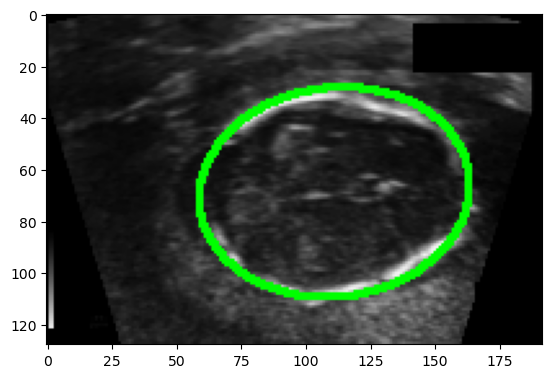

In [24]:
show_img_mask(np.squeeze(img),np.squeeze(mask))

In [25]:
from sklearn.model_selection import ShuffleSplit

In [26]:
sss = ShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 0)

indices = range(len(fetal_ds1))

for train_index, val_index in sss.split(indices):
    print(len(train_index))
    print("-"*10)
    print(len(val_index))

799
----------
200


In [27]:
from torch.utils.data import Subset

train_ds = Subset(fetal_ds1, train_index)
print(len(train_ds))

val_ds = Subset(fetal_ds2, val_index)
print(len(val_ds))



799
200


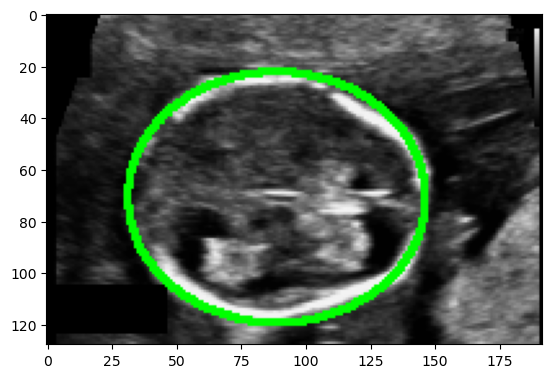

In [28]:
for img,mask in train_ds:
    show_img_mask(np.squeeze(img),np.squeeze(mask))
    break

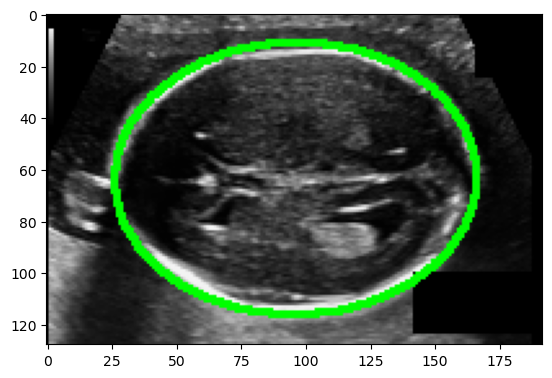

In [29]:
for img,mask in val_ds:
    show_img_mask(np.squeeze(img),np.squeeze(mask))
    break

In [32]:
from torch.utils.data import DataLoader

train_dl = DataLoader(train_ds, batch_size=8, shuffle = True)

val_dl = DataLoader(val_ds, batch_size=8, shuffle = False)

In [33]:
for x,y in train_dl:
    print(x.shape, x.dtype)
    print(y.shape, y.dtype)
    break
for x,y in val_dl:
    print(x.shape, x.dtype)
    print(y.shape, y.dtype)
    break

torch.Size([8, 1, 128, 192]) torch.float32
torch.Size([8, 1, 128, 192]) torch.float32
torch.Size([8, 1, 128, 192]) torch.float32
torch.Size([8, 1, 128, 192]) torch.float32


## Defining the model - encoder–decoder

In [34]:
import torch.nn as nn
import torch.nn.functional as F

In [37]:
class SegNet(nn.Module):
    def __init__(self, params):
        super(SegNet, self).__init__()
        C_in, H_in, W_in = params["input_shape"] #(1, height, width)
        init_f = params["initial_filters"] #number of filters in the first CNN layer
        num_outputs = params["num_outputs"]#pass 1 for single- object segmentation
        
        
        #five CNN blocks for down-sampling the input,
        # an up-sampling block, and another five CNN blocks for up-sampling the feature map.

        self.conv1 = nn.Conv2d(C_in, init_f, kernel_size = 3, stride = 1, padding = 1)
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size = 3, stride = 1, padding = 1)
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size = 3, stride = 1, padding = 1)
        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size = 3, stride = 1, padding = 1)
        self.conv5 = nn.Conv2d(8*init_f, 16*init_f, kernel_size = 3, stride = 1, padding = 1)
        
        self.upsample = nn.Upsample(scale_factor = 2, mode = 'bilinear', align_corners = True)
        
        self.conv_up1 = nn.Conv2d(16*init_f,8*init_f, kernel_size= 3, padding = 1)
        self.conv_up2 = nn.Conv2d(8*init_f,4*init_f, kernel_size= 3, padding = 1)
        self.conv_up3 = nn.Conv2d(4*init_f,2*init_f, kernel_size= 3, padding = 1)
        self.conv_up4 = nn.Conv2d(2*init_f,init_f, kernel_size= 3, padding = 1)
        
        self.conv_out = nn.Conv2d(init_f, num_outputs, kernel_size=3, padding = 1)
        
    def forward(self,x):
        #Encoder
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        
        
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        
        
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)
        
        
        x = F.relu(self.conv5(x))
        
        # Decoder
        x = self.upsample(x)
        x = F.relu(self.conv_up1(x))
        
        
        x = self.upsample(x)
        x = F.relu(self.conv_up2(x))
        
        
        x = self.upsample(x)
        x = F.relu(self.conv_up3(x))
        
        
        x = self.upsample(x)
        x = F.relu(self.conv_up4(x))
        
        x = self.conv_out(x)
        
        return x
        
        
        
        
        

In [38]:
params_model = {
    "input_shape": (1,h,w), 
    "initial_filters": 16,
    "num_outputs": 1,
}
model = SegNet(params_model)

In [42]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
model = model.to(device)

from torchsummary import summary 
summary(model, input_size=(1, h, w), device=device.type)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 192]             160
            Conv2d-2           [-1, 32, 64, 96]           4,640
            Conv2d-3           [-1, 64, 32, 48]          18,496
            Conv2d-4          [-1, 128, 16, 24]          73,856
            Conv2d-5           [-1, 256, 8, 12]         295,168
          Upsample-6          [-1, 256, 16, 24]               0
            Conv2d-7          [-1, 128, 16, 24]         295,040
          Upsample-8          [-1, 128, 32, 48]               0
            Conv2d-9           [-1, 64, 32, 48]          73,792
         Upsample-10           [-1, 64, 64, 96]               0
           Conv2d-11           [-1, 32, 64, 96]          18,464
         Upsample-12         [-1, 32, 128, 192]               0
           Conv2d-13         [-1, 16, 128, 192]           4,624
           Conv2d-14          [-1, 1, 1

In [43]:
import torch.nn.functional as F

def dice_loss(pred,target, smooth = 1e-5):
    intersection = (pred*target).sum(dim= (2,3))
    union = pred.sum(dim= (2,3)) + target.sum(dim= (2,3))
    dice = 2.0 * (intersection+smooth)/(union+smooth)
    loss = 1-dice
    return loss.sum(), dice.sum()

def loss_func(pred,target):
    bce = F.binary_cross_entropy_with_logits(pred, target, reduction = 'sum')
    pred = torch.sigmoid(pred)
    div,_ = dice_loss(pred,target)
    loss = bce + div
    return loss


def metric_batch(pred, target):
    pred = torch.sigmoid(pred)
    _,metric  = dice_loss(pred, target)
    return metric

In [44]:
def loss_batch(loss_func, output, target, opt = None):
    loss = loss_func(output,target)
    _, metric_b = dice_loss(torch.sigmoid(output), target)
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
        
    return loss.item(), metric_b

In [45]:
from torch import optim
from tqdm import tqdm
opt = optim.Adam(model.parameters(), lr = 3e-4)

In [46]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode = 'min', factor = 0.5, patience=20, verbose = 1)


In [47]:
def loss_epoch(model, loss_func, dataset_dl, sanity_check = False, opt= None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)
    
    for xb,yb in tqdm(dataset_dl):
        xb = xb.type(torch.float32).to(device)
#         print(device)
        yb  = yb.type(torch.float32).to(device)
        
        output = model(xb)
        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)
        running_loss += loss_b
        running_metric += metric_b
        
    loss = running_loss/len_data
    metric = running_metric/len_data
    
    return loss, metric

In [48]:
def get_lr(opt):
    
    for param in opt.param_groups:
        return param['lr']

In [49]:
import copy

def train_val(model, params):
    num_epochs=params["num_epochs"]
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]
    
    
    loss_history = {
        "train": [],
        "val": []
    }
    
    metric_history = {
        "train": [],
        "val": []
    }
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    
    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        
        print(f"Epochs: {epoch+1}/{num_epochs} Current Learning Rate: {current_lr}")
        
        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt = opt)
        loss_history['train'].append(train_loss)
        metric_history["train"].append(train_metric)
        
        model.eval()
        with torch.no_grad():
            
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check, opt = None)
            loss_history['val'].append(val_loss)
            metric_history["val"].append(val_metric)
        
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print("Best model saved")
            
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print("loading best wts")
            model.load_state_dict(best_model_wts)
            
        print("train loss: %.6f, dice: %.2f" %(train_loss,100*train_metric)) 
        print("val loss: %.6f, dice: %.2f" %(val_loss,100*val_metric))
        print("-"*10)
        
    model.load_state_dict(best_model_wts)
    
    return model, loss_history, metric_history

            
    

In [53]:
torch.cuda.empty_cache()


In [54]:
params_train={
"num_epochs": 33,
"optimizer": opt,
"loss_func": loss_func,
"train_dl": train_dl,
"val_dl": val_dl,
"sanity_check": False,
"lr_scheduler": lr_scheduler,
"path2weights": "./"+"weights.pt",
}

In [ ]:
model,loss_hist,metric_hist=train_val(model,params_train)



Epochs: 1/33 Current Learning Rate: 0.0003


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:25<00:00,  1.01s/it]


Best model saved
train loss: 8751.275398, dice: 55.46
val loss: 7065.016250, dice: 65.42
----------
Epochs: 2/33 Current Learning Rate: 0.0003


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:24<00:00,  1.03it/s]


Best model saved
train loss: 6207.712922, dice: 71.05
val loss: 5634.630313, dice: 75.20
----------
Epochs: 3/33 Current Learning Rate: 0.0003


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:16<00:00,  1.54it/s]


Best model saved
train loss: 5090.735111, dice: 75.15
val loss: 4411.767842, dice: 77.56
----------
Epochs: 4/33 Current Learning Rate: 0.0003


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:15<00:00,  1.61it/s]


Best model saved
train loss: 4121.840743, dice: 79.14
val loss: 3877.678799, dice: 80.40
----------
Epochs: 5/33 Current Learning Rate: 0.0003


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:16<00:00,  1.55it/s]


Best model saved
train loss: 3504.161156, dice: 82.07
val loss: 3213.519531, dice: 83.76
----------
Epochs: 6/33 Current Learning Rate: 0.0003


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:15<00:00,  1.63it/s]


Best model saved
train loss: 3137.199170, dice: 83.83
val loss: 2768.664521, dice: 84.99
----------
Epochs: 7/33 Current Learning Rate: 0.0003


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:16<00:00,  1.55it/s]


Best model saved
train loss: 2700.385294, dice: 86.04
val loss: 2433.274980, dice: 86.33
----------
Epochs: 8/33 Current Learning Rate: 0.0003


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 82/100 [02:48<01:03,  3.55s/it]

In [ ]:
num_epochs = params_train['num_epochs']

plt.figure()
plt.plot(range(1, num_epochs+1), loss_hist['train'], label = 'train')

plt.plot(range(1, num_epochs+1), loss_hist['val'], label = 'val')
plt.xlabel("Numer of Epochs")
plt.ylabel("Loss")
plt.title("Train_val_loss")
plt.legend()


In [ ]:
num_epochs = params_train['num_epochs']

plt.figure()
plt.plot(range(1, num_epochs+1), metric_hist['train'], label = 'train')

plt.plot(range(1, num_epochs+1), metric_hist['val'], label = 'val')
plt.xlabel("Numer of Epochs")
plt.ylabel("Loss")
plt.title("Accuracy(Dice)")
plt.legend()


### Deploying the Model

In [ ]:
path2testdata ="./data/training_set/"

img_list = os.listdir(path2testdata)

In [ ]:
rnd_imgs = np.random.choice(img_list, 4)

In [ ]:
for i in rnd_imgs:
    model.eval()
    with torch.no_grad():
        img = Image.open(os.path.join(path2testdata, i))
        img = img.resize((w,h))
        img_t = to_tensor(img).unsqueeze(0).to(device)
        pred = model(img_t)
        pred=torch.sigmoid(pred)[0]
        mask_pred= (pred[0]>=0.5)
    plt.figure(figsize=(10,10))
    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap="gray")
    plt.subplot(1, 3, 2)
    plt.imshow(mask_pred.cpu().detach().numpy(), cmap="gray")
    plt.subplot(1, 3, 3)
    show_img_mask(img, mask_pred.cpu().detach().numpy())
    